# Pretrained WhisperBrain Audio Benchmarking

In [1]:
from whisper.brain import initialize_from_whisper, WillettDataset
import whisper
import torch
import pandas as pd
import numpy as np
from whisper.normalizers import EnglishTextNormalizer

In [2]:
# check if cuda is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


This notebook goes through the process of initializing a new WhisperBrain model, loading pretrained weights for Whisper part of the model, and evaluating the audio decoding performance of the model on the synthetic speech produced by the data_tools module. This serves as an upper bound on how well the neural decoder will likely perform without any fine-tuning of the Whisper componant of the WhisperBrain model.

In [3]:
model = initialize_from_whisper(name='tiny.en')
model.to(DEVICE)
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)
dataset = WillettDataset("K:\ke\sta\data\Willett&EtAl2023\data\Willett&EtAl2023.h5", "train", device=DEVICE)
options = whisper.DecodingOptions(language="en", without_timestamps=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
tokenizer = whisper.tokenizer.get_tokenizer("en")
text_normalizer = EnglishTextNormalizer()

Model is English-only and has 1,837,638,786 parameters.


In [4]:
def encode_texts(texts):
    # remove white space from start and end
    clean_texts = [text_normalizer(text) for text in texts]
    sots = list(tokenizer.sot_sequence_including_notimestamps)
    eot = [tokenizer.eot]
    token_map = map(tokenizer.encode, texts)
    token_array = []
    for tokens in token_map:
        token_array.append(sots + tokens + eot)
    token_array = torch.tensor(token_array, dtype=torch.long, device=DEVICE)
    return token_array

In [6]:
brain_data, mels, texts, signal_lengths = dataloader.__iter__().__next__()
audio_embeddings = model.embed_audio(mels)
tokens = encode_texts(texts)
logits = model.logits(tokens, audio_embeddings)
logits.shape

torch.Size([1, 49, 51864])

Decoding

In [4]:
hypotheses = []
references = []
batches = len(dataloader)
for i, (neural_data, mels, texts, signal_lengths) in enumerate(dataloader):
    print(f"Batch {i+1}/{batches} ({len(hypotheses)} hypotheses so far)")
    audio_results = model.decode(mels, options)
    hypotheses.extend([result.text for result in audio_results])
    references.extend(texts)
    if i == 10:
        break

Batch 1/3460 (0 hypotheses so far)
Batch 2/3460 (1 hypotheses so far)
Batch 3/3460 (2 hypotheses so far)
Batch 4/3460 (3 hypotheses so far)
Batch 5/3460 (4 hypotheses so far)
Batch 6/3460 (5 hypotheses so far)
Batch 7/3460 (6 hypotheses so far)
Batch 8/3460 (7 hypotheses so far)
Batch 9/3460 (8 hypotheses so far)
Batch 10/3460 (9 hypotheses so far)
Batch 11/3460 (10 hypotheses so far)
Batch 12/3460 (11 hypotheses so far)
Batch 13/3460 (12 hypotheses so far)
Batch 14/3460 (13 hypotheses so far)
Batch 15/3460 (14 hypotheses so far)
Batch 16/3460 (15 hypotheses so far)
Batch 17/3460 (16 hypotheses so far)
Batch 18/3460 (17 hypotheses so far)
Batch 19/3460 (18 hypotheses so far)
Batch 20/3460 (19 hypotheses so far)
Batch 21/3460 (20 hypotheses so far)
Batch 22/3460 (21 hypotheses so far)
Batch 23/3460 (22 hypotheses so far)
Batch 24/3460 (23 hypotheses so far)
Batch 25/3460 (24 hypotheses so far)
Batch 26/3460 (25 hypotheses so far)
Batch 27/3460 (26 hypotheses so far)
Batch 28/3460 (27 hy

In [5]:
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))
data

,hypothesis,reference
0,What do you think about places?,What do you think about places? ...
1,Its carbon so that makes sense.,It's carbon so that makes sense. ...
2,I didn't even really think about it that much.,I didn't even really think about it that much.
3,She is thinner than I am.,She is thinner than I am. ...
4,That is just personal feeling.,That is just personal feeling. ...
...,...,...
3455,A midnight surprise and lots of joy,A midnight surprise and lots of joy. ...
3456,You got young boys or girls.,You got young boys or girls.
3457,Maybe today will be a good news day.,Maybe today'll be a good-news day.
3458,After five years,After five years. ...


# Calculating the word error rate

Now, we use our English normalizer implementation to standardize the transcription and calculate the WER.

In [16]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

In [17]:
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

,hypothesis,reference,hypothesis_clean,reference_clean
0,What do you think about places?,What do you think about places? ...,what do you think about places,what do you think about places
1,Its carbon so that makes sense.,It's carbon so that makes sense. ...,its carbon so that makes sense,it is carbon so that makes sense
2,I didn't even really think about it that much.,I didn't even really think about it that much.,i did not even really think about it that much,i did not even really think about it that much
3,She is thinner than I am.,She is thinner than I am. ...,she is thinner than i am,she is thinner than i am
4,That is just personal feeling.,That is just personal feeling. ...,that is just personal feeling,that is just personal feeling
...,...,...,...,...
3455,A midnight surprise and lots of joy,A midnight surprise and lots of joy. ...,a midnight surprise and lots of joy,a midnight surprise and lots of joy
3456,You got young boys or girls.,You got young boys or girls.,you got young boys or girls,you got young boys or girls
3457,Maybe today will be a good news day.,Maybe today'll be a good-news day.,maybe today will be a good news day,maybe today will be a good news day
3458,After five years,After five years. ...,after 5 years,after 5 years


In [18]:
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")

WER: 2.74 %


# Visualizing Embeedings

In [21]:
neural_data, mels, texts, signal_lengths = dataloader.__iter__().__next__()
audio_embedding = model.encoder(mels)
brain_embedding = model.brain_encoder(neural_data)
audio_embedding.shape
brain_embedding.shape

torch.Size([1, 1500, 384])

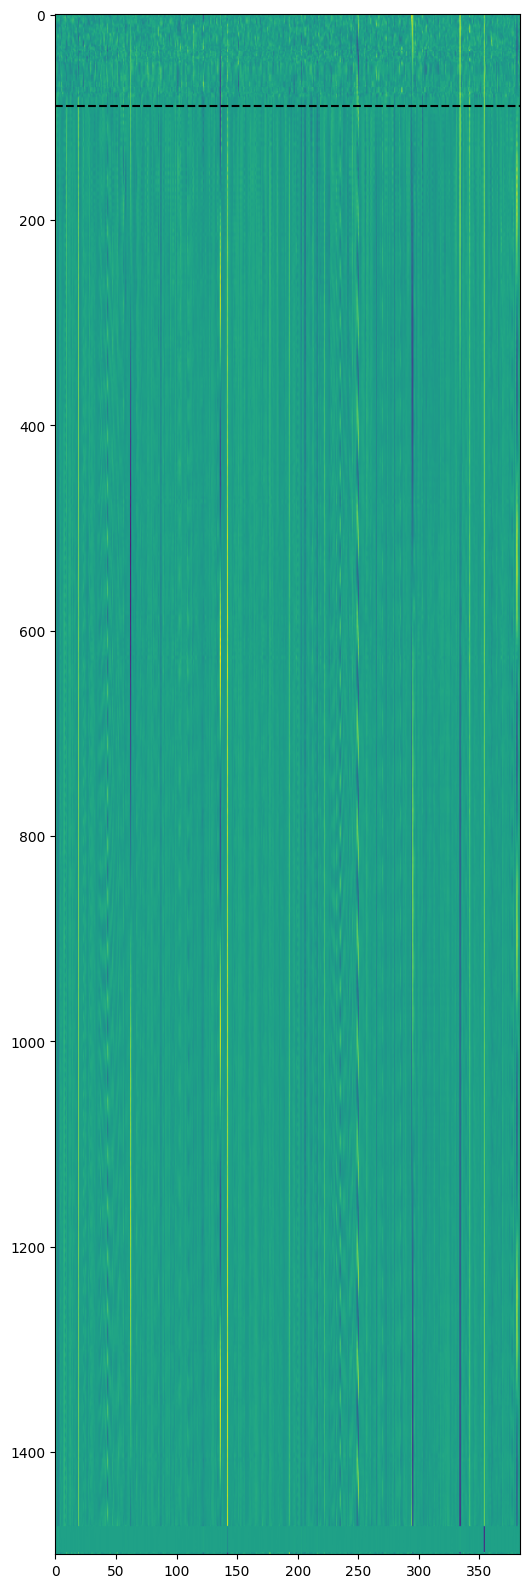

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 20))
# draw a horizontal line at the y axis location signal_length//2
plt.axhline(signal_lengths[0] // 2, color="black", linestyle="--")
plt.imshow(audio_embedding.squeeze(0).cpu().detach().numpy(), aspect="auto", cmap="viridis")

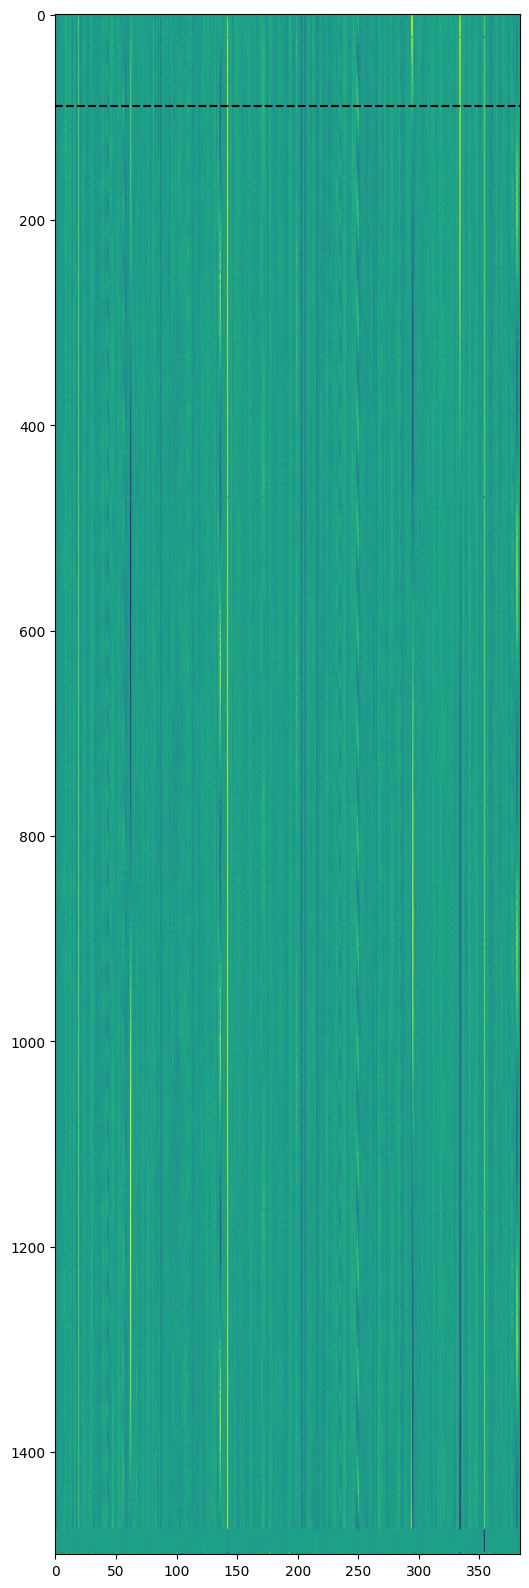

In [23]:
plt.figure(figsize=(6, 20))
plt.axhline(signal_lengths[0] // 2, color="black", linestyle="--")
plt.imshow(brain_embedding.squeeze(0).cpu().detach().numpy(), aspect="auto", cmap="viridis")